In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
def load_data(train_path: str, test_path: str):
    """
    Load training and testing data from CSV files.
    """
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

def preprocess_data(train_data: pd.DataFrame, test_data: pd.DataFrame, one_hot_column: str = 'flat_model'):
    """
    Perform one-hot encoding on the flat_model column and ensure train and test have the same set of columns.
    """
    train_data = pd.get_dummies(train_data, columns=[one_hot_column], prefix='model')
    test_data = pd.get_dummies(test_data, columns=[one_hot_column], prefix='model')
    
    # Ensure both train and test have the same one-hot encoded columns
    train_columns = set(train_data.columns)
    test_columns = set(test_data.columns)
    for col in train_columns - test_columns:
        if col.startswith('model_'):
            test_data[col] = 0
    extra_columns = [col for col in test_data.columns if col.startswith('model_') and col not in train_columns]
    test_data.drop(columns=extra_columns, inplace=True)
    
    return train_data, test_data

def define_features(train_data: pd.DataFrame, test_data: pd.DataFrame):
    """
    Define feature columns and the target column based on the dataset.
    Numeric features: time, storey_avg, floor_area_sqm, flat_type_encoded, remaining_lease_months.
    All one-hot encoded columns from flat_model start with 'model_'.
    """
    numeric_features = ['time', 'storey_avg', 'floor_area_sqm', 'flat_type_encoded', 'remaining_lease_months']
    model_columns = [col for col in train_data.columns if col.startswith('model_')]
    feature_columns = numeric_features + model_columns
    target_column = 'resale_price'
    
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]
    y_test = test_data[target_column]
    
    return X_train, y_train, X_test, y_test, feature_columns

In [ ]:
def train_xgb_model(X_train: pd.DataFrame, y_train: pd.Series, cv: int = 3, n_iter: int = 20, random_state: int = 42):
    """
    Train an XGBoost model
    """
    param_distributions = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    
    xgb_model = XGBRegressor(random_state=random_state, objective='reg:squarederror')
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    print("Best Parameters from RandomizedSearchCV:")
    print(random_search.best_params_)
    
    return random_search.best_estimator_, random_search

In [4]:
def predict_and_evaluate(model, X_test: pd.DataFrame, y_test: pd.Series):
    """
    Make predictions using the trained model and evaluate performance.
    """
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print("\nXGBoost Model Evaluation:")
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    return predictions, mae, rmse

In [ ]:
def project_future_value(model, sample_row: pd.DataFrame, feature_columns: list, steps: int = 120, 
                           lease_decay_factor: float = 0.001, estate_upgrade_factor: float = 0.0005, 
                           ura_adjustment_factor: float = 0.0003):
    """
    Projects the future resale price for a single data row for a number of months (default: 120 months).

    For each month, the function:
      - Increases 'time' by 1.
      - Decreases 'remaining_lease_months' by 1 (not dropping below 0).
      - Predicts the baseline resale price using the trained model.
      - Applies an adjustment based on supplied factors:
            lease_decay_factor (represents depreciation),
            estate_upgrade_factor (represents improvements/upgrades), and
            ura_adjustment_factor (captures master plan development effects).
    
    Parameters:
      - model: Trained model for prediction.
      - sample_row: A one-row DataFrame representing the initial flat data.
      - feature_columns: List of features used by the model.
      - steps: Number of months to project (default: 120).
      - lease_decay_factor: Monthly depreciation factor.
      - estate_upgrade_factor: Monthly appreciation factor from estate upgrades.
      - ura_adjustment_factor: Monthly adjustment factor from URA master plan developments.
    
    Returns:
      - future_prices: List of adjusted predicted prices for each future month.
    """
    current_row = sample_row.copy().iloc[0]
    future_prices = []
    
    for month in range(1, steps+1):
        current_row['time'] += 1
        current_row['remaining_lease_months'] = max(current_row['remaining_lease_months'] - 1, 0)
        
        current_features = pd.DataFrame([current_row[feature_columns]]
        baseline_price = model.predict(current_features)[0]
        
        adjustment_rate = (estate_upgrade_factor + ura_adjustment_factor - lease_decay_factor)
        adjusted_price = baseline_price * (1 + adjustment_rate * month)
        
        future_prices.append(adjusted_price)
    
    return future_prices

In [10]:
def plot_future_trend(future_prices: list):
    """
    Plot the future price trend over the projection period.
    """
    months = list(range(1, len(future_prices) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(months, future_prices, marker='o', linestyle='-')
    plt.title("10-Year Future Price Projection")
    plt.xlabel("Months from now")
    plt.ylabel("Projected Resale Price")
    plt.grid(True)
    plt.show()

In [18]:

train_data = pd.read_csv('../../data/processed/train.csv')
test_data = pd.read_csv('../../data/processed/test.csv')
    
train_data, test_data = preprocess_data(train_data, test_data, one_hot_column='flat_model')
X_train, y_train, X_test, y_test, feature_columns = define_features(train_data, test_data)
    
model, random_search = train_xgb_model(X_train, y_train)
    
predictions, mae, rmse = predict_and_evaluate(model, X_test, y_test)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters from RandomizedSearchCV:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

XGBoost Model Evaluation:
Mean Absolute Error (MAE): 53670.33516329242
Root Mean Squared Error (RMSE): 77600.80163564642


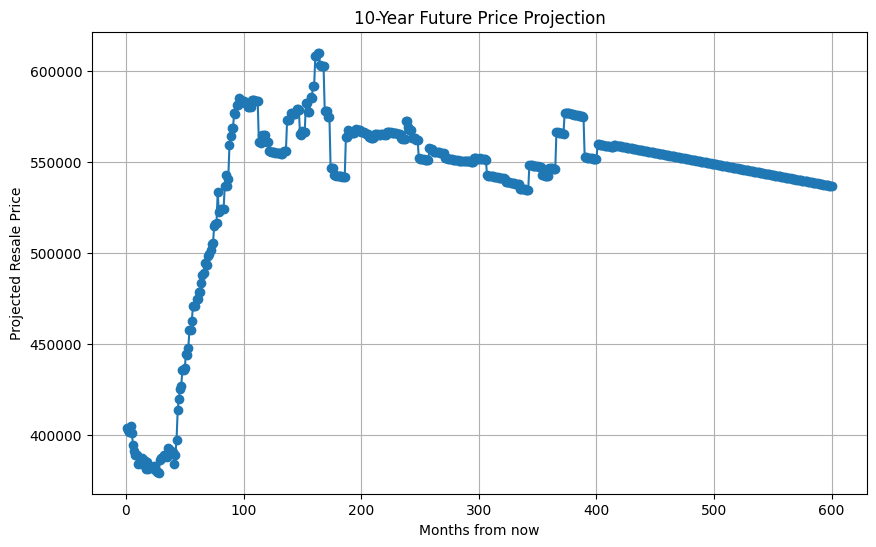

In [ ]:
sample_data = {
        'time': [1],
        'storey_avg': [5],
        'floor_area_sqm': [100.0],
        'flat_type_encoded': [4],
        'remaining_lease_months': [966]
}

for col in feature_columns:
    if col.startswith('model_'):
        sample_data[col] = [1 if col == 'model_Model A' else 0]
    
sample_row = pd.DataFrame(sample_data)
    
# Project future prices over 120 months.
future_prices = project_future_value(model, sample_row, feature_columns, steps=120, 
                                        lease_decay_factor=0.001, 
                                        estate_upgrade_factor=0.0005, 
                                        ura_adjustment_factor=0.0003)
    
plot_future_trend(future_prices)
